In [1]:
import os
os.chdir('../')
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
import numpy as np
from xgboost import XGBClassifier
import time
from sklearn.metrics import *
from scipy import stats 
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('error')

# Reading Data

In [3]:
data = pd.read_csv('data/UNSW_NB15_training-set.csv',index_col='id')
data.head()

dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
id                                                                          
1   0.121478   tcp       -   FIN      6      4     258     172  74.087490   
2   0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
3   1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
4   1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
5   0.449454   tcp       -   FIN     10      6     534     268  33.373826   

    sttl  dttl         sload          dload  sloss  dloss      sinpkt  \
id                                                                      
1    252   254  14158.942380    8495.365234      0      0   24.295600   
2     62   252   8395.112305  503571.312500      2     17   49.915000   
3     62   252   1572.271851   60929.230470      1      6  231.875571   
4     62   252   2740.178955    3358.622070      1      3  152.876547   
5    254   252   8561.499023    3987.059814      2      1   47.750333   

        dinpkt          sjit          djit  swin       stcpb       dtcpb  \
id                                                                         
1     8.375000     30.177547     11.830604   255   621772692  2202533631   
2    15.432865     61.426934   1387.778330   255  1417884146  3077387971   
3   102.737203  17179.586860  11420.926230   255  2116150707  2963114973   
4    90.235726    259.080172   4991.784669   255  1107119177  1047442890   
5    75.659602   2415.837634    115.807000   255  2436137549  1977154190   

    dwin    tcprtt    synack    ackdat  smean  dmean  trans_depth  \
id                                                                  
1    255  0.000000  0.000000  0.000000     43     43            0   
2    255  0.000000  0.000000  0.000000     52   1106            0   
3    255  0.111897  0.061458  0.050439     46    824            0   
4    255  0.000000  0.000000  0.000000     52     64            0   
5    255  0.128381  0.071147  0.057234     53     45            0   

    response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  \
id                                                                              
1                   0           1             0           1                 1   
2                   0          43             1           1                 1   
3                   0           7             1           2                 1   
4                   0           1             1           2                 1   
5                   0          43             1           2                 2   

    ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
id                                                               
1                  1               1             0           0   
2                  1               2             0           0   
3                  1               3             0           0   
4                  1               3             1           1   
5                  1              40             0           0   

    ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports attack_cat  \
id                                                                         
1                  0           1           1                0     Normal   
2                  0           1           6                0     Normal   
3                  0           2           6                0     Normal   
4                  0           2           1                0     Normal   
5                  0           2          39                0     Normal   

    label  
id         
1       0  
2       0  
3       0  
4       0  
5       0

# Plots to understand Skewness

In [4]:
#function to plot distplots for all the columns
def plotfig(s):
    sns.distplot(df[df["label"]==0][s], hist=False,label="No Attack")
    sns.distplot(df[df["label"]==1][s], hist=False,label="Attack")
    plt.legend()
    plt.show()

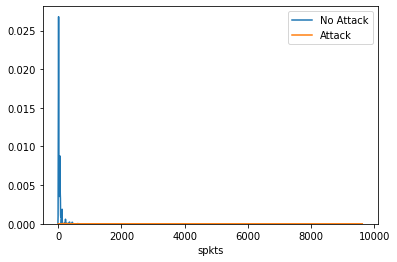

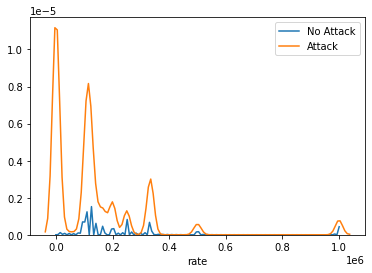

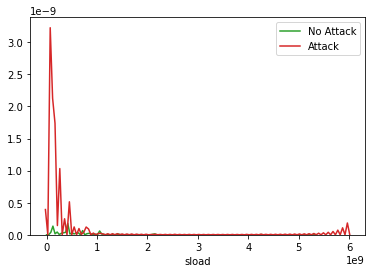

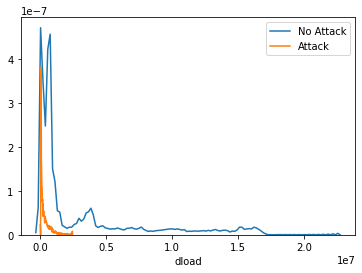

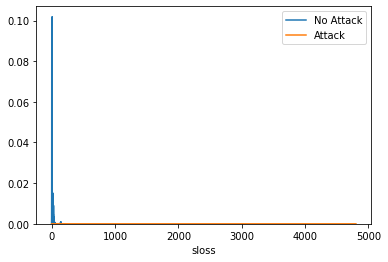

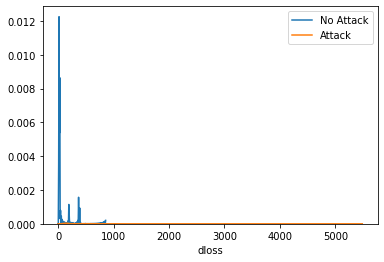

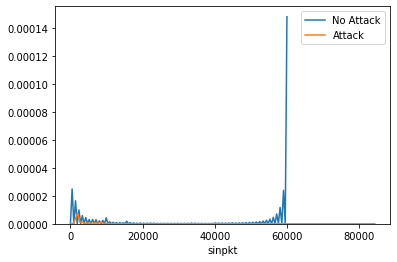

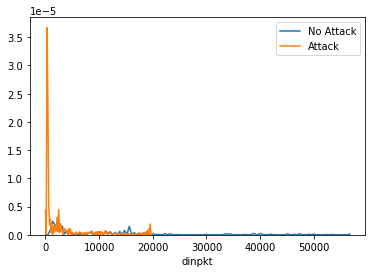

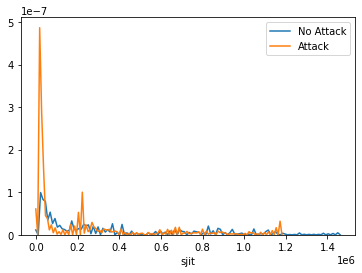

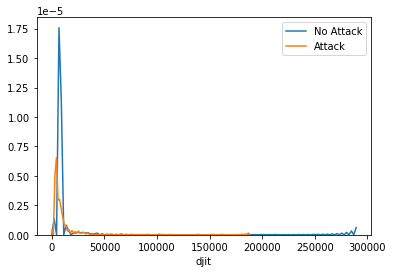

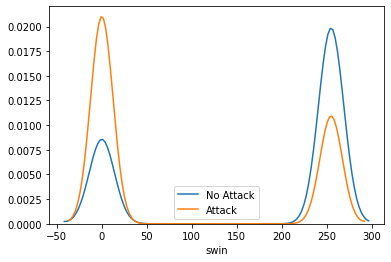

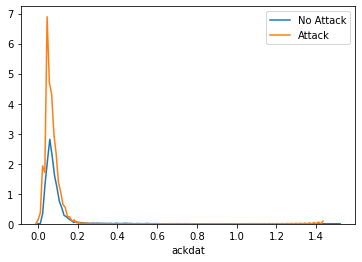

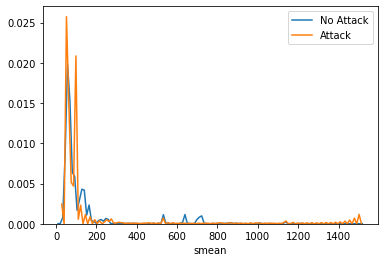

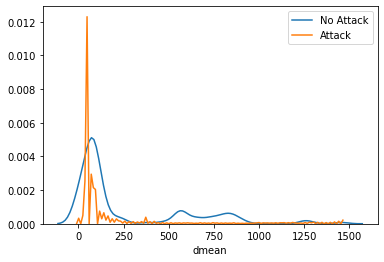

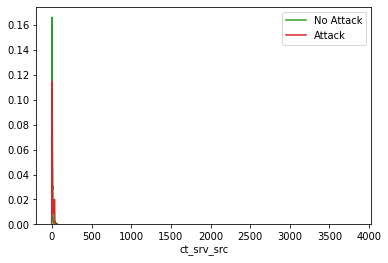

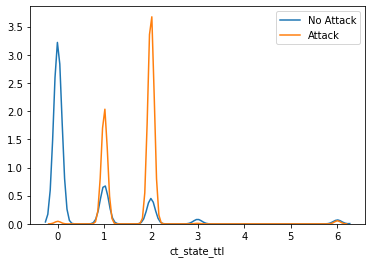

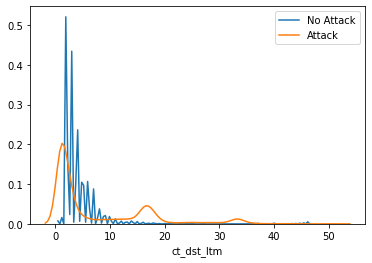

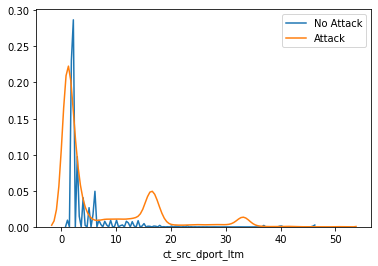

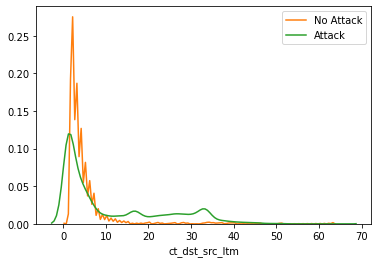

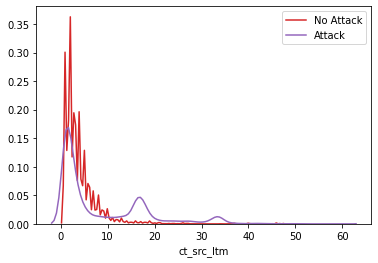

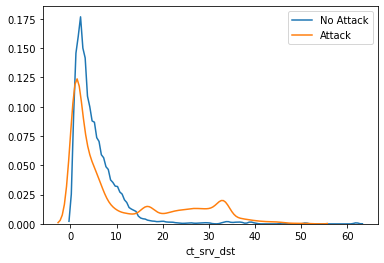

In [5]:
#Graphs
df=pd.read_csv('data/UNSW_NB15_training-set.csv',index_col='id')
df=df.drop(['attack_cat','proto','service','state'], axis=1)
col=df.columns
norm = []
for i in range(len(col)-2):
    try:
        plotfig(col[i])
    except:
        norm.append(col[i])

In [6]:
# List of columns with no Skewness treatment
norm

['sttl',
 'dttl',
 'trans_depth',
 'response_body_len',
 'ct_dst_sport_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd']

# Preprocessing

In [7]:
def preprocess_initial(df):
    
    # Categorical variables
    dummies1 = pd.get_dummies(data['proto'],drop_first= True)
    dummies2 = pd.get_dummies(data['service'],drop_first= True)
    dummies3 = pd.get_dummies(data['state'],drop_first= True)
    
    
    right = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', "rate",
           'sload', 'dload', 'sloss', 'dloss', 'dinpkt', 'sjit',
            'djit',"swin", 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
             'ackdat', 'smean', 'dmean','ct_srv_src', 'ct_dst_ltm', 
             'ct_src_dport_ltm','ct_dst_src_ltm', 
             'ct_src_ltm', 'ct_srv_dst','ct_state_ttl']
    
    left = ['sinpkt']
    
    # Correcting Skewness
    for i in left:
        df[i] = df[i]**3
        
    for i in right:
        df[i] = (df[i]+1).transform(np.log)
    
    # Joining and droping from dataframe
    df       = pd.concat([dummies1, dummies2, dummies3, df], axis=1)
    df       = df.drop(['attack_cat','proto','service','state'], axis=1)
    return df

In [8]:
def preprocess_final(X_train, X_test, y_train, y_test):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Model

In [9]:
def f_score(X_train, X_test, y_train, y_test):
    
    model = XGBClassifier(silent=True,
                      booster = 'gbtree',
                     objective='binary:logistic',
                      n_estimators=5000, 
                        learning_rate = 0.05,
                      max_depth=10,
                        verbosity=0
                     )
    eval_set = [(X_test, y_test)]
    eval_metric = ["logloss"]
    model.fit(X_train, y_train,early_stopping_rounds=100, eval_metric=eval_metric, eval_set=eval_set)
    
    yxgb=model.predict(X_test)
    f_weighted = f1_score(y_true=y_test,y_pred=yxgb,average="weighted")
    f_macro = f1_score(y_true=y_test,y_pred=yxgb,average="macro")
    acc = accuracy_score(y_true=y_test,y_pred=yxgb)
    return (f_weighted,f_macro,acc)

## Taking average over 10 Splits of DataSet to generalise Result

In [10]:
def category(X,y):
    
    l_w = []
    l_m = []
    l_a = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    fold = 0
    for train_ix, test_ix in kfold.split(X, y):
        fold+=1
        
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        X_train, X_test, y_train, y_test = preprocess_final(X_train, X_test, y_train, y_test)
        
        score_w,score_m,score_a  = f_score(X_train, X_test, y_train, y_test)
        l_w.append(score_w)
        l_m.append(score_m)
        l_a.append(score_a)
            
        print(f"Completed Fold{fold}")
    
    return sum(l_w)/len(l_w) , sum(l_m)/len(l_m) , sum(l_a)/len(l_a)

In [11]:
df_final = preprocess_initial(data)
train_y  = df_final['label']
train_x  = df_final.drop(['label'],axis=1)

result1, result2, result3 = category(train_x.values,train_y.values)

[0]	validation_0-logloss:0.65154
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.61387
[2]	validation_0-logloss:0.57950
[3]	validation_0-logloss:0.54811
[4]	validation_0-logloss:0.51945
[5]	validation_0-logloss:0.49304
[6]	validation_0-logloss:0.46871
[7]	validation_0-logloss:0.44625
[8]	validation_0-logloss:0.42546
[9]	validation_0-logloss:0.40619
[10]	validation_0-logloss:0.38808
[11]	validation_0-logloss:0.37127
[12]	validation_0-logloss:0.35564
[13]	validation_0-logloss:0.34108
[14]	validation_0-logloss:0.32749
[15]	validation_0-logloss:0.31466
[16]	validation_0-logloss:0.30266
[17]	validation_0-logloss:0.29139
[18]	validation_0-logloss:0.28087
[19]	validation_0-logloss:0.27097
[20]	validation_0-logloss:0.26164
[21]	validation_0-logloss:0.25292
[22]	validation_0-logloss:0.24463
[23]	validation_0-logloss:0.23686
[24]	validation_0-logloss:0.22954
[25]	validation_0-logloss:0.22267
[26]	validation_0-logloss:0.21613
[27]	validation_0-loglos

In [12]:
print(f"Weighted F1 Score: {result1}, Macro F1 Score: {result2}, Average Accuracy: {result3}")

Weighted F1 Score: 0.9633239126254077, Macro F1 Score: 0.9576606715185983, Average Accuracy: 0.9634654684829366


# After Feature Selection

In [13]:
df_final = preprocess_initial(data)
train_y  = df_final['label']
train_x  = df_final.drop(['label'],axis=1)
bin1 = sorted([(i,j,k) for j,i,k in zip(f_classif(train_x, train_y)[0],f_classif(train_x, train_y)[1],train_x.columns)],key = lambda x: (x[0],-x[1]))
bin1

[(0.0, 216806.27495996302, 'ct_state_ttl'),
 (0.0, 161780.5269520456, 'sttl'),
 (0.0, 77460.96280031546, 'dload'),
 (0.0, 64599.6960514644, 'dmean'),
 (0.0, 61481.060966977246, 'dbytes'),
 (0.0, 59703.33285994361, 'INT'),
 (0.0, 53992.52761530672, 'dpkts'),
 (0.0, 34906.86311093543, 'dloss'),
 (0.0, 27072.56469770108, 'sloss'),
 (0.0, 25645.955323792747, 'ct_dst_sport_ltm'),
 (0.0, 25007.032739295846, 'spkts'),
 (0.0, 23188.71222214385, 'ct_src_dport_ltm'),
 (0.0, 21975.51803988375, 'tcp'),
 (0.0, 21973.27169163021, 'swin'),
 (0.0, 19983.366379116273, 'stcpb'),
 (0.0, 19956.87204062203, 'dwin'),
 (0.0, 19942.340929764454, 'dtcpb'),
 (0.0, 18362.733022761324, 'sbytes'),
 (0.0, 17765.07828754023, 'FIN'),
 (0.0, 14306.866575710283, 'sload'),
 (0.0, 11377.151264398573, 'ct_dst_src_ltm'),
 (0.0, 10236.51786391375, 'sjit'),
 (0.0, 9280.836574293331, 'djit'),
 (0.0, 8705.376446429913, 'rate'),
 (0.0, 8072.298756787505, 'dns'),
 (0.0, 6420.504454216441, 'arp'),
 (0.0, 6309.110652735729, 'unas'

In [14]:
imp = [i[2] for i in bin1][:30]

In [15]:
result1, result2, result3 = category(train_x[imp].values,train_y.values)

[0]	validation_0-logloss:0.65155
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.61392
[2]	validation_0-logloss:0.57966
[3]	validation_0-logloss:0.54845
[4]	validation_0-logloss:0.51982
[5]	validation_0-logloss:0.49351
[6]	validation_0-logloss:0.46928
[7]	validation_0-logloss:0.44689
[8]	validation_0-logloss:0.42617
[9]	validation_0-logloss:0.40696
[10]	validation_0-logloss:0.38899
[11]	validation_0-logloss:0.37230
[12]	validation_0-logloss:0.35684
[13]	validation_0-logloss:0.34236
[14]	validation_0-logloss:0.32890
[15]	validation_0-logloss:0.31622
[16]	validation_0-logloss:0.30434
[17]	validation_0-logloss:0.29324
[18]	validation_0-logloss:0.28277
[19]	validation_0-logloss:0.27296
[20]	validation_0-logloss:0.26366
[21]	validation_0-logloss:0.25490
[22]	validation_0-logloss:0.24665
[23]	validation_0-logloss:0.23901
[24]	validation_0-logloss:0.23183
[25]	validation_0-logloss:0.22505
[26]	validation_0-logloss:0.21864
[27]	validation_0-loglos

In [16]:
print(f"Weighted F1 Score: {result1}, Macro F1 Score: {result2}, Average Accuracy: {result3}")

Weighted F1 Score: 0.9583139882500327, Macro F1 Score: 0.9518333605696657, Average Accuracy: 0.9585151195433769
